<h1> DS200A Computer Vision Assignment</h1>

<h2>  Part Two: Exploratory data analysis and feature extraction. </h2>	


<h5> In this section, Compute at least 15 such image features (a method for each), including the following (NOTE: At least 10 of these must be scalar features and 2 matrix-based features): (i) image size, (ii) average of the red-channel intensity, (iii) aspectratio. This will require significant explatoratory research and data analysis. The first one is already implemented for you, and the next two are pre-specified. Additional requirements specfied in pdf. </h5>

In [391]:
# Scalar feature
def ft0(image):
    # Returns the pixel size of the image
    return image.size

# Scalar feature
def ft1(image):
    # Returns the average of the red-channel pictures for the images
    if image.ndim != 3:
        return 0
    return np.mean(image[:, :, 0])

# Scalar feature
def ft2(image):
    # Returns the aspect ratio of the image
    height, width = image.shape[:2]
    return width / height

# Scalar feature
def ft3(image):
    # Returns the average of the blue-channel pictures for the images
    if image.ndim != 3:
        return 0
    return np.mean(image[:, :, 2])

# Scalar feature
def ft4(image):
    # Returns the average of the green-channel pictures for the images
    if image.ndim != 3:
        return 0
    return np.mean(image[:, :, 1])

# Matrix feature
# def ft_orb(image):  

 We expect all external sources sited, and significant indication of EDA. 

In this part, we focus on the learning set. Let's load the data first.

In [159]:
import pandas as pd
import numpy as np

learning = pd.read_pickle("train.pkl")
print(learning.shape)
learning.head()

(1501, 2)


,Pictures,Encodings
0,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",0
1,"[[[88, 56, 17], [95, 63, 24], [101, 69, 30], [...",0
2,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",0
3,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",0
4,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",0


Next, let's try to display 3 of the learning set images.

Label = penguin
Label = gorilla
Label = dolphin


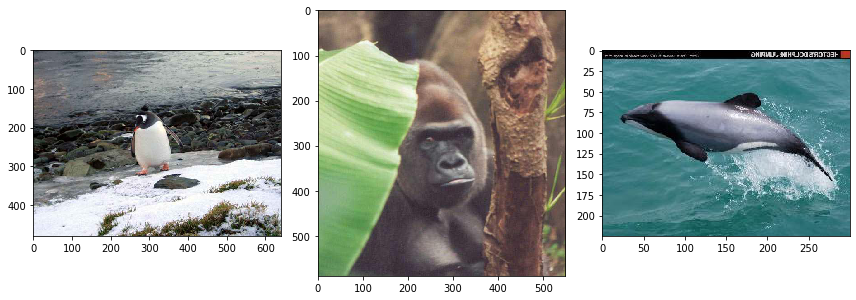

In [160]:
import skimage
from matplotlib import pyplot as plt

labels = pd.read_csv("labels.csv", index_col=0)

sample = learning.sample(3, random_state=42)
fig=plt.figure(figsize=(12, 7))
for i in range(len(sample)):
    row = sample.iloc[i]
    fig.add_subplot(1, 3, i + 1)
    skimage.io.imshow(row["Pictures"])
    print('Label = ' + labels.iloc[row["Encodings"]].labels)
plt.show()

Alright, everything seems working. We have an image of a penguin, a gorilla, and a dolphin.

Let's visualize the distribution of the classes to examine how imbalanced this dataset is.

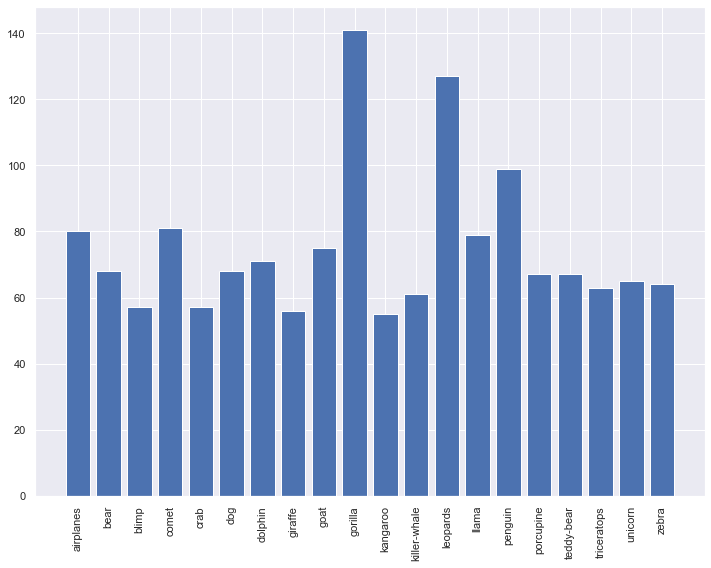

In [387]:
sns.set()
train = learning.copy()
train["name"] = train["Encodings"].apply(lambda x: labels["labels"][x])
plt.figure(figsize=(12, 9))
class_dist = train.groupby("name").size()
plt.bar(x=class_dist.index, height=class_dist.values)
plt.xticks(rotation=90);

The good news is that the dataset is not too imbalanced. Most classes have a frequency of 60 - 80. However, there are exceptions. For instance, there're as much as 140 gorilla pictures, 120+ leopard pictures, and almost 100 penguin pictures.

<h4> Graphs </h4>

First, let's investigate the size of the images across different classes.

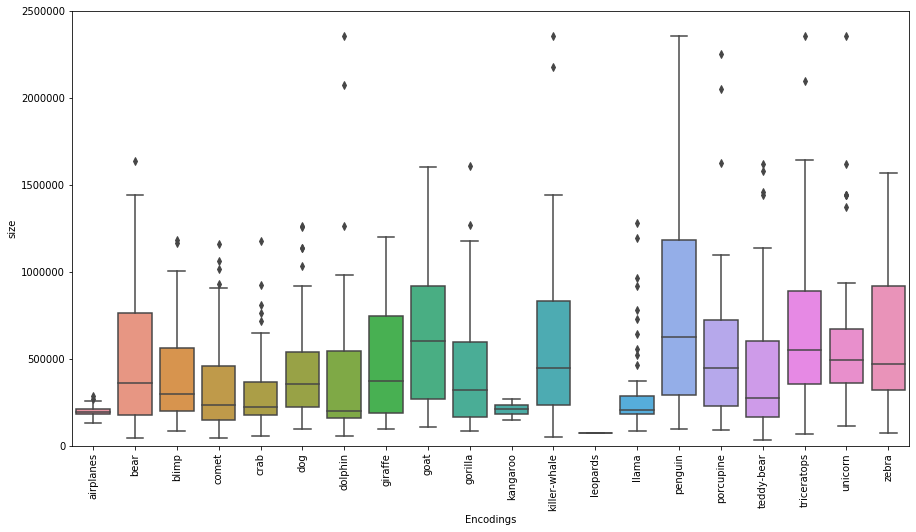

In [161]:
import seaborn as sns

train_cpy = learning.copy()
train_cpy["size"] = learning["Pictures"].apply(ft0)

plt.figure(figsize=(15,8))
ax = sns.boxplot(x="Encodings", y="size", data=train_cpy)
ax.set(ylim=(0, 2.5e6))
ax.set_xticklabels(labels['labels'], rotation=90);

Ignoring the outliers, we notice that almost all leopards have a small image size. The same goes for airplanes, kangaroo, and llama. By contrast, penguin has much variance in image sizes with a rather high the median value. In general, we observe a great variety of image size distributions for different classes, so it might be a feature that can help us differentiate between classes. However, we don't observe a particular, explainable pattern here.

Second, let's examine the average red-channel intensity.

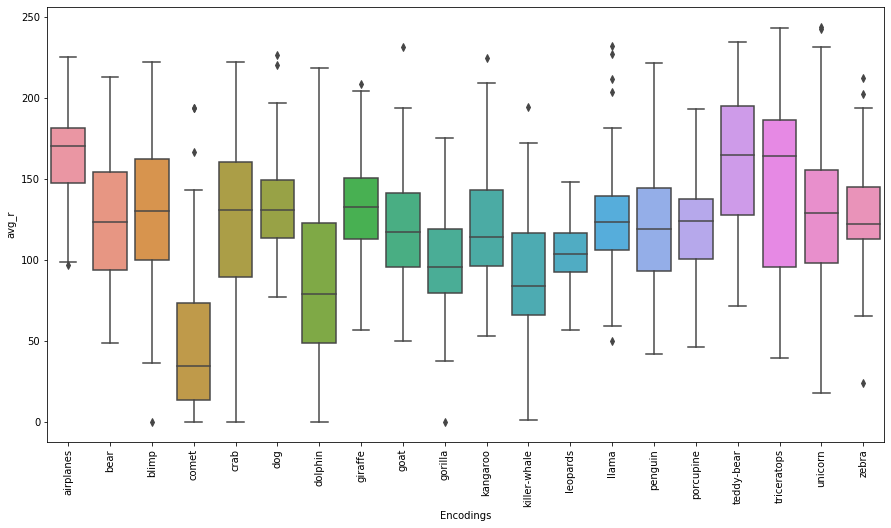

In [162]:
train_cpy["avg_r"] = learning["Pictures"].apply(ft1)
train_cpy.head()

plt.figure(figsize=(15,8))
ax = sns.boxplot(x="Encodings", y="avg_r", data=train_cpy)
ax.set_xticklabels(labels['labels'], rotation=90);

Interestingly, commet images exhibit low average red intensity. This should not be a big surprise because commet pictures we see are usually in a black background. Teddy bear and triceratops have high red intensity, probably due to their brown color. However, it is very interesting that airplanes have high red intensity. Let's look at some airplane pictures to understand why.

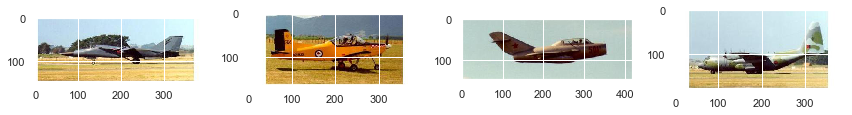

In [393]:
def show_sample_images(name):
    airplane_sample = learning[learning["Encodings"] == list(labels["labels"]).index(name)].sample(4, random_state=42)
    fig=plt.figure(figsize=(12, 7))
    for i in range(len(airplane_sample)):
        row = airplane_sample.iloc[i]
        fig.add_subplot(1, len(airplane_sample), i + 1)
        skimage.io.imshow(row["Pictures"])
    plt.show()


show_sample_images("airplanes")

We see that many airplane pictures have the bright sky as background. This may be the reason why airplane pictures have high red intensity because its background is almost as bright as white. Anyways, red intensity may also be a helpful feature for identifying classes like commets and airplanes.

Third, let's examine the aspect ratio feature.

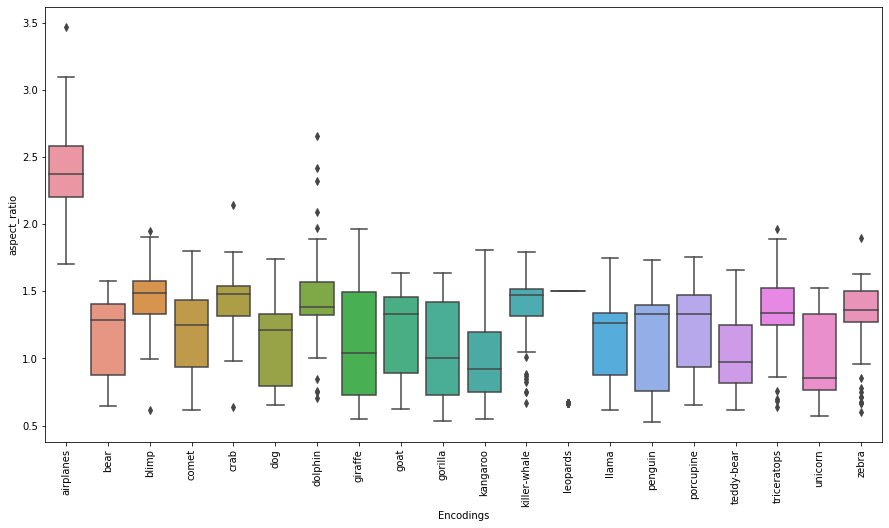

In [173]:
train_cpy["aspect_ratio"] = learning["Pictures"].apply(ft2)
train_cpy.head()

plt.figure(figsize=(15,8))
ax = sns.boxplot(x="Encodings", y="aspect_ratio", data=train_cpy)
ax.set_xticklabels(labels['labels'], rotation=90);

Airplane images have a very high aspect ratio. Judging from our sample images, most airplane pictures are flat, because that fits with the position in which the airplane flys. Sensibly, airplanes seldome fly vertically. Therefore, aspect ratio is a good feature for identifying airplanes.

Interestingly, almost all leopards have the same aspect ratio, which could be helpful in making predictions.

Let's continue with color intensities. Let's try the average blue-channel intensity.

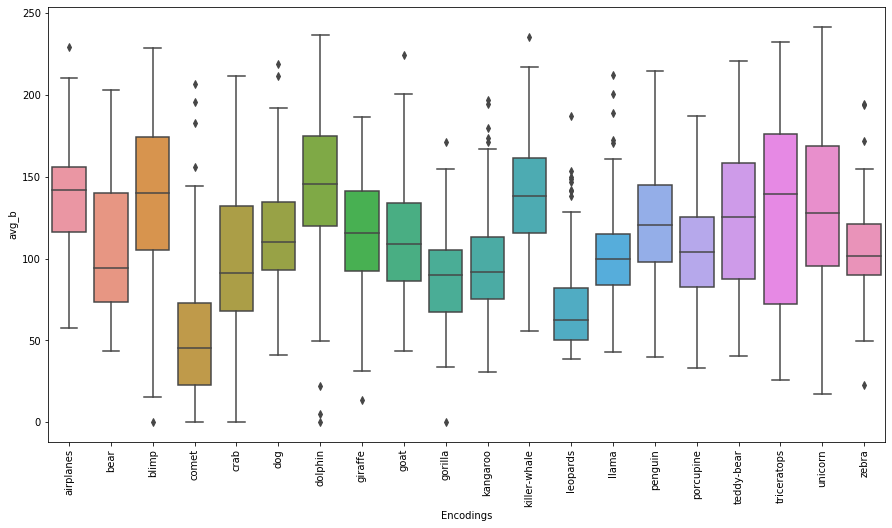

In [182]:
train_cpy["avg_b"] = learning["Pictures"].apply(ft3)
train_cpy.head()

plt.figure(figsize=(15,8))
ax = sns.boxplot(x="Encodings", y="avg_b", data=train_cpy)
ax.set_xticklabels(labels['labels'], rotation=90);

The box plot looks quite different from that of average red intensity. Specifically, airplanes, blimp, dolphin, and killer-whale stand out. It's not too much of a surprise, since all these categories are associated with water or sky, which are predominantly blue. Therefore, it could count as a useful feature.

We've examined Red and Blue in RGB. The distribution of average *green*-channel intensity is quiet similar to that of red-channel.

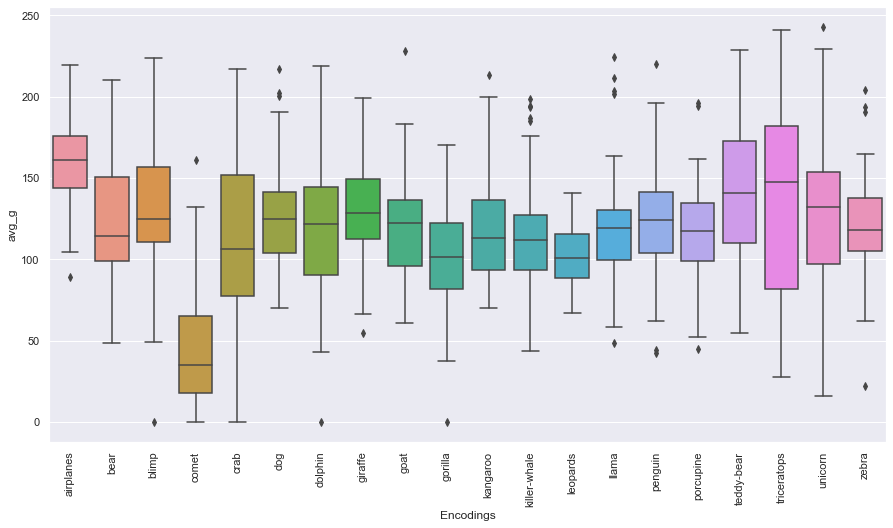

In [392]:
train_cpy["avg_g"] = learning["Pictures"].apply(ft4)
train_cpy.head()

plt.figure(figsize=(15,8))
ax = sns.boxplot(x="Encodings", y="avg_g", data=train_cpy)
ax.set_xticklabels(labels['labels'], rotation=90);

However, there are indeed differences between average red and green intensity. In particular, dolphin has visibly high average green intensity than red intensity. Let's examine a few example images to understand why.

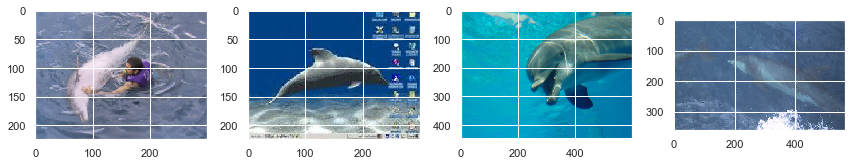

In [394]:
show_sample_images("dolphin")

Notice that the theme color of dolphin images is mostly *cyan*, which is a combination of green and blue. This explains dolphin images' relatively high green and blue intensity and low red intensity.

Now, let's try using Bag of Visual Words (BoVW).

First, let's get all the descriptors from the training set.

In [307]:
import cv2

orb = cv2.ORB_create()  # Use ORB feature detector
des_ls = []

for img in learning["Pictures"]:
    keypoints = orb.detect(img, None)
    keypoints, descriptors = orb.compute(img, keypoints)
    des_ls.append(descriptors)

In [322]:
all_des = des_ls[0]
for i in range(1, len(des_ls)):
    if (des_ls[i] is None):
        print(i)
    else:
        all_des = np.concatenate((all_des, des_ls[i]))

213
246


It seems some images have `None` descriptors. We need to take note of that in our data processing.

Then, we perform K Means clustering to build histogram features.

In [309]:
# Perform K Means clustering
from sklearn.cluster import KMeans
n_clusters = 20
kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(all_des)

In [320]:
import pickle
pickle.dump(kmeans, open(f"kmeans_{n_clusters}.pkl", "wb"))

Now, create the Bag of Visual Words feature matrix for all iamges.

In [335]:
def get_descriptors(img):
    orb = cv2.ORB_create()
    kp = orb.detect(img, None)
    _, des = orb.compute(img, kp)
    return des


def build_histogram(img, kmeans):
    hist = np.zeros(len(kmeans.cluster_centers_))
    des = get_descriptors(img)
    if (des is None):
        return hist
    pred = kmeans.predict(des)
    for i in pred:
        hist[i] += 1
    return hist


all_hist = build_histogram(learning["Pictures"].iloc[0], kmeans)
for i in range(1, len(learning)):
    hist = build_histogram(learning["Pictures"].iloc[i], kmeans)
    all_hist = np.vstack((all_hist, hist))    

In [348]:
orb_feature_df = pd.DataFrame(all_hist)
train = pd.concat([learning, orb_feature_df], axis=1)
train.head()

,Pictures,Encodings,0,1,2,3,4,5,6,7,...,10,11,12,13,14,15,16,17,18,19
0,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",0,33.0,24.0,9.0,10.0,12.0,14.0,23.0,26.0,...,51.0,37.0,9.0,13.0,15.0,13.0,5.0,10.0,20.0,25.0
1,"[[[88, 56, 17], [95, 63, 24], [101, 69, 30], [...",0,29.0,22.0,43.0,24.0,13.0,21.0,29.0,9.0,...,5.0,22.0,35.0,18.0,40.0,24.0,21.0,25.0,6.0,4.0
2,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",0,46.0,17.0,2.0,27.0,18.0,9.0,37.0,21.0,...,36.0,13.0,8.0,25.0,7.0,3.0,14.0,16.0,50.0,33.0
3,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",0,42.0,10.0,4.0,17.0,11.0,8.0,32.0,24.0,...,21.0,40.0,3.0,26.0,14.0,20.0,5.0,29.0,39.0,35.0
4,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",0,18.0,25.0,23.0,20.0,17.0,5.0,25.0,19.0,...,11.0,11.0,11.0,49.0,19.0,7.0,11.0,14.0,29.0,19.0


<h4> Sources </h4>

<h4> DataFrame Creation </h4>

In [2]:
def feature_frame(df):
    return df
    #Returns data-frame with all the features now inside, and calculated


In [3]:
feature_frame(data_from_nb1)

NameError: name 'starting_data' is not defined